# Cost-Sensitive Learning

In many real-world classification scenarios, the costs associated with incorrect predictions are asymmetric. This means that the cost of a false positive is different from that of a false negative. Often, one class is less prevalent but holds higher importance than the other, leading to imbalanced datasets. Minimizing these asymmetric costs does not always align perfectly with maximizing metrics like the area under the receiver operating characteristic curve (AUC-ROC) or F1-score. Additionally, relying on a probability threshold of 0.5, the default decision value for most classifiers, may not result in optimal model performance. To address the issue of asymmetric costs, advanced modeling techniques can be employed.

Consider an online retail company planning a direct-mail marketing campaign to promote a new product. The company has compiled purchase histories and demographic information for each customer to target a subset of individuals with offers. From previous campaigns, several factors impact the cost of sending an offer:

1. Design
2. Materials
3. Printing and production
4. Postage and delivery
5. Labor and overhead

Each offer costs $\$5$ to produce and send. Customers who redeem an offer typically make purchases totaling $\$50$. The objective of the campaign is to maximize revenue from redeemed offers while effectively managing costs.

A predictive model will be built using the customer data to identify individuals most likely to redeem an offer and make a purchase. In this retail scenario, the costs associated with misclassification are asymmetric:

- **False Positive (FP):** Sending the offer to someone who will not make a purchase, incurring a $\$5$ cost.
- **False Negative (FN):** Not sending an offer to someone who would have made a purchase, representing a missed opportunity cost of $\$45$ (the $\$50$ purchase minus the $\$5$ offer cost).
- **True Positive (TP):** Sending an offer to someone who will make a purchase, incurring a $\$5$ cost.
- **True Negative (TN):** Not sending an offer to someone who would not have made a purchase, incurring $\$0$ cost.

The costs can be summarized in the following matrix, where $N$ represents the number of customers in each classification bucket:

|                   | Actual Negative | Actual Positive |
|-------------------|-----------------|-----------------|
| **Predicted Negative** | $0N_{tn}$       | $45N_{fn}$      |
| **Predicted Positive** | $5N_{fp}$       | $5N_{tp}$       |

The total profit can be calculated as:

$$\textrm{Total Profit} = 50N_{tp} - (5N_{tp} + 5N_{fp} + 45N_{fn})$$

There are several ways to approach the problem of asymmetric costs. Two common methods include:

1. **Incorporating Class Weights:** Assigning misclassification costs during training alters the model’s loss function and decision boundary, ensuring greater attention is paid to the more valuable class.
2. **Threshold Optimization:** After training, optimizing the decision threshold minimizes misclassification costs. This threshold is often different from the standard probability threshold of 0.5.

Both approaches will be explored in this context.

Let’s get started by importing some useful libraries and loading the data!

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from joblib import load
from matplotlib.pyplot import *
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

In [4]:
df = pd.read_csv('data/marketing_campaign.csv')

In [5]:
df.head()

,Age,Education,Marital Status,Income,Num Children in Home,Num Teens in Home,Years Customer,Recency,Amount Spent Channel 1,Amount Spent Channel 2,Amount Spent Channel 3,Amount Spent Channel 4,Amount Spent Channel 5,Amount Spent Channel 6,Num Deal Purchases,Num Web Purchases,Num Catalog Purchases,Num Store Purchases,Num Web Visits Month,Accepted Offer 3,Accepted Offer 4,Accepted Offer 5,Accepted Offer 1,Accepted Offer 2,Complaint,Target
0,55.675720,High School,Single,58138.0,0,0,3.323842,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1
1,60.182346,High School,Single,46344.0,1,1,1.817983,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0
2,48.636513,High School,Coupled,71613.0,0,0,2.362830,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0
3,30.111707,High School,Coupled,26646.0,1,0,1.889169,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0
4,33.049502,Some College,Married,58293.0,1,0,1.949403,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0


The dataset includes demographic information and purchase histories for over two thousand customers. The demographic data include features like age, education level, marital status, and income, offering a comprehensive overview of the customer base. The purchase histories include dollar amounts spent across different product channels, number of purchases through different sales media, and features indicating whether a customer has redeemed other prior offers.

The data are split into training and test sets prior to analysis. The training set, containing 1,563 records, will be used to build the predictive model, while the test set, containing 670 records, will be used to evaluate model performance.

In [6]:
x_tr, x_te, y_tr, y_te = train_test_split(df.drop('Target', axis=1), df['Target'], stratify=df['Target'], test_size=0.3, random_state=0)

In [7]:
print(y_te.sum())

99


The test set contains 99 customers who will redeem an offer and make a purchase.

## Baseline Models

The function below will display the costs, revenue gained from purchases, and the total profit for models under different scenarios.

In [8]:
def compute_cost_metrics(model_name, y_actual, y_predict, max_profit=None, return_profit=False):

    tn, fn, fp, tp = confusion_matrix(y_actual, y_predict).T.flatten()

    exp_r = tp * revenue_sale

    exp_c = (tp * cost_offer) + \
            (fp * cost_offer) + \
            (fn * (revenue_sale - cost_offer))

    if max_profit is None: max_profit = (exp_r - exp_c)

    print(f"""
        \033[1m{model_name}\033[0m
        Revenue: ${exp_r:,}
        Costs: ${exp_c:,}
        Total profit: ${(exp_r - exp_c):,}
        Percent of max: {100 * (exp_r - exp_c) / max_profit:0.1f}%
        """)

    if return_profit == True: return (exp_r - exp_c)

The cost associated with producing and mailing an offer is \\$5, and the average purchase amount upon redeeming an offer is \$50. We can set those variables here.

In [9]:
cost_offer = 5

revenue_sale = 50

Let's first use the test set to compute the expected profit from a perfect model. The **Perfect Model** is one in which only customers who will certainly make a purchase are sent an offer. It generates no false positive or false negatives, resulting in the maximum possible revenue through purchases while minimizing costs. In reality, it is never the case where the purchasers are known ahead of time, but the Perfect model will set a limit as to the maximum profit any model could hope to achieve.

In [10]:
max_profit = compute_cost_metrics(model_name='Perfect Model', y_actual=y_te, y_predict=y_te, return_profit=True)


        Perfect Model
        Revenue: $4,950
        Costs: $495
        Total profit: $4,455
        Percent of max: 100.0%
        


The Perfect model results in a total profit of \\$4,455. Next, a Baseline model can be produced which simply sends an offer to every customer in the dataset.

In [11]:
baseline_profit = compute_cost_metrics(model_name='Baseline Model', y_actual=y_te, y_predict=np.ones(len(y_te)), max_profit=max_profit, return_profit=True)


        Baseline Model
        Revenue: $4,950
        Costs: $3,350
        Total profit: $1,600
        Percent of max: 35.9%
        


The **Baseline Model** generates a large revenue but also incurs a very high cost as a result of so many false positives. The total profit is just \\$1,600, or 35.9% that of the Perfect model.

Now let's employ cost-sensitive learning to create models that can generate high revenue but are able to more effectively manage costs. Two models will be built - one with class weights and one without. The models will be incorporated as part of a scikit-learn pipeline. This will allow for the simultaneous one-hot encoding of categorical features, and the scaling of numerical ones when necessary.

## Cost-Sensitive Modeling

In [12]:
categorical_columns = x_tr.select_dtypes('object').columns.tolist()

numerical_columns = x_tr.select_dtypes('number').columns.tolist()

In [13]:
numerical_transformer = Pipeline(
    steps=[
        ('scaler', None)
    ]
)

In [14]:
categorical_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_columns),
        ('categorical', categorical_transformer, categorical_columns)
    ]
)

Three model types will be tested here: logistic regression, random forests, and support vector classifiers. Hyperparameters for each will be incorporated in a parameter grid that will be searched using ```GridSearchCV```. The models with the best ROC AUC scores for the two class weight scenarioes will be used for analysis.

In [16]:
class_weight = {0: cost_offer, 1: (revenue_sale - cost_offer)}

param_grid = [
    {
        'classifier': [LogisticRegression(max_iter=500, class_weight=class_weight, random_state=0)],
        'classifier__C': np.logspace(-3, 2, 20),
        'classifier__solver': ['lbfgs', 'liblinear'],
        'preprocessor__numerical__scaler': [MinMaxScaler(), StandardScaler()]
    },
    {
        'classifier': [RandomForestClassifier(class_weight=class_weight, random_state=0)],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [3, 6, 9, 12, None],
        'classifier__n_estimators': [100, 200, 300, 500],
    },
    {
        'classifier': [SVC(probability=True, class_weight=class_weight, random_state=0)],
        'classifier__C': np.logspace(-3, 2, 20),
        'classifier__gamma': ['scale', 'auto'],
        'classifier__kernel': ['linear', 'poly', 'rbf'],
        'preprocessor__numerical__scaler': [MinMaxScaler(), StandardScaler()]
    }
]

In [16]:
pipeline = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', None)
    ]
)

In [738]:
grid_cv = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc', cv=5, refit=True, n_jobs=5)

grid_cv.fit(x_tr, y_tr);

The the hyperparameters for the two best-performing models are shown below. The models perform nearly identically in terms of ROC AUC score.

- **Without Class Weights**
    * Model: SVC(probability=True, class_weight=None)
    * C: 16.238
    * gamma: 'auto'
    * kernel: 'rbf'
    * scaler: MinMaxScaler()
    * AUC score: 0.887
<br/><br/>
- **With Class Weights**
    * Model: LogisticRegression(max_iter=500, class_weight={0: 5, 1: 45})
    * C: 0.428
    * solver: 'liblinear'
    * scaler: MinMaxScaler()
    * AUC score: 0.889

Let's load the saved models and apply them to the test set.

In [55]:
model_wo = load('models/cost_sensitive_without_class_weight.joblib')

model_wi = load('models/cost_sensitive_with_class_weight.joblib')

In [56]:
predict_wo = model_wo.predict_proba(x_te)[:, 1]

predict_wi = model_wi.predict_proba(x_te)[:, 1]

The predictions can now be used to examine the expected profit from each model.

In [57]:
compute_cost_metrics('Without Class Weights', y_actual=y_te, y_predict=(predict_wo >= 0.5), max_profit=max_profit)


        Without Class Weights
        Revenue: $2,450
        Costs: $2,575
        Total profit: $-125
        Percent of max: -2.8%
        


In [58]:
compute_cost_metrics('With Class Weights', y_actual=y_te, y_predict=(predict_wi >= 0.5), max_profit=max_profit)


        With Class Weights
        Revenue: $4,450
        Costs: $1,580
        Total profit: $2,870
        Percent of max: 64.4%
        


In situations involving imbalanced datasets, relying on the standard decision threshold probability of 0.5 frequently leads to poor predictive performance. This is exemplified by the **Without Class Weights Model** where the total profit is negative, indicating an overall loss. The performance of this model can be improved significantly through proper tuning of the decision threshold.

Conversely, the **With Class Weights Model** performs well with the default classificaiton threshold, yielding a profit reaching 64.4% that of the **Perfect Model**. This is an 80% increase over the **Baseline Model** in which all customers are contacted. Despite this improvement, the performance of this model can also be further optimized through threshold tuning.

Let's compare the ROC curves for the two models.

In [59]:
fpr_a, tpr_a, threshold_a = roc_curve(y_te, predict_wo)

fpr_b, tpr_b, threshold_b = roc_curve(y_te, predict_wi)

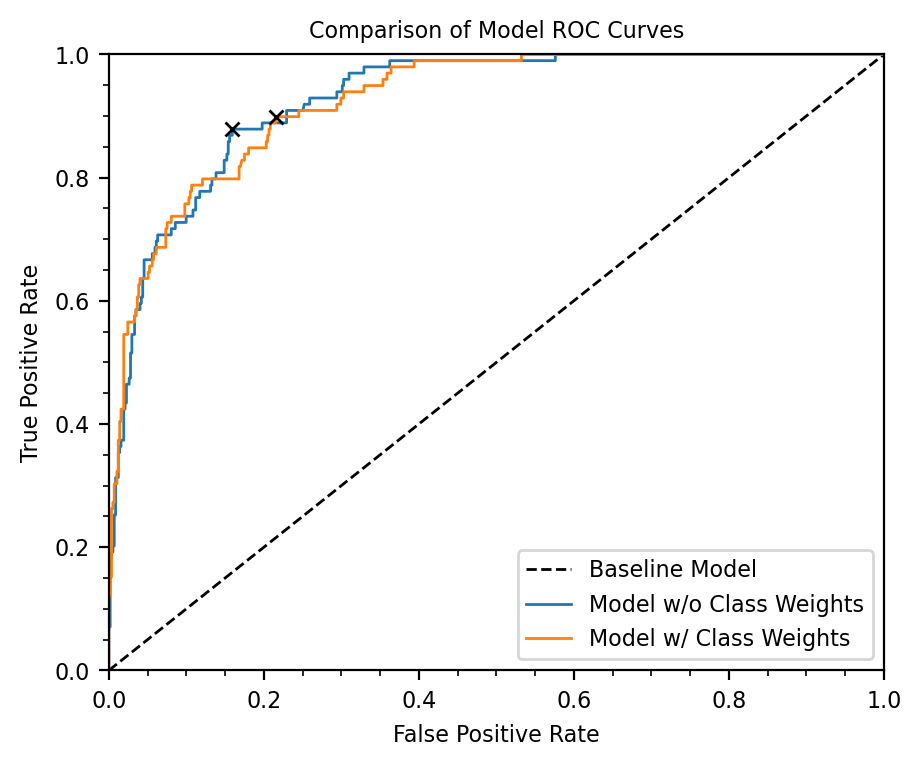

In [69]:
fig, axs = subplots(nrows=1, ncols=1, figsize=(5, 4))

axs.plot([0, 1], [0, 1], '--k', lw=1)

axs.plot(fpr_a, tpr_a, lw=1)
axs.plot(fpr_b, tpr_b, lw=1)

axs.plot([fpr_a[np.argmax(tpr_a + (1 - fpr_a))], fpr_b[np.argmax(tpr_b + (1 - fpr_b))]],
         [tpr_a[np.argmax(tpr_a + (1 - fpr_a))], tpr_b[np.argmax(tpr_b + (1 - fpr_b))]], 'xk', ms=5)

axs.minorticks_on()
axs.tick_params(axis='both', labelsize=8)

axs.set_ylim(0, 1)
axs.set_xlim(0, 1)
axs.set_ylabel('True Positive Rate', fontsize=8)
axs.set_xlabel('False Positive Rate', fontsize=8)
axs.set_title('Comparison of Model ROC Curves', fontsize=8)
axs.legend(['Baseline Model', 'Model w/o Class Weights', 'Model w/ Class Weights'], fontsize=8);

The black points on the two curves indicate their approximate elbow. The elbow marks the decision threshold where the true positive rate is maximized and the false positive rate is minimized, and represents the "optimal" model when costs are considered symmetric. Let's compute the expected profit using these two threshold values.

In [61]:
compute_cost_metrics('Without Class Weights, Optimal ROC Threshold',
                     y_actual=y_te,
                     y_predict=predict_wo >= threshold_a[np.argmax(tpr_a + (1 - fpr_a))],
                     max_profit=max_profit)


        Without Class Weights, Optimal ROC Threshold
        Revenue: $4,350
        Costs: $1,430
        Total profit: $2,920
        Percent of max: 65.5%
        


In [62]:
compute_cost_metrics('With Class Weights, Optimal ROC Threshold',
                     y_actual=y_te,
                     y_predict=predict_wi >= threshold_b[np.argmax(tpr_b + (1 - fpr_b))],
                     max_profit=max_profit)


        With Class Weights, Optimal ROC Threshold
        Revenue: $4,450
        Costs: $1,510
        Total profit: $2,940
        Percent of max: 66.0%
        


We can see that the **With Class Weights Model** performs only slightly better than before, but the **Without Class Weights Model** shows significant improvement. Both models have now reached an expected profit that is approximately 65% that of the **Perfect Model**.

Finally, we can create a function to compute the expected profit over a series of different thresholds.

In [63]:
def compute_profit(y_actual, y_predict):

    threshold = np.linspace(0, 1, 100)

    tn, fn, fp, tp = np.stack([confusion_matrix(y_actual, y_predict >= i).T.flatten() for i in threshold], axis=0).T

    exp_r = tp * revenue_sale

    exp_c = (tp * cost_offer) + \
            (fp * cost_offer) + \
            (fn * (revenue_sale - cost_offer))

    return (exp_r - exp_c), threshold

In [64]:
profit_wo, threshold = compute_profit(y_actual=y_te, y_predict=predict_wo)

profit_wi, threshold = compute_profit(y_actual=y_te, y_predict=predict_wi)

Let's plot the results.

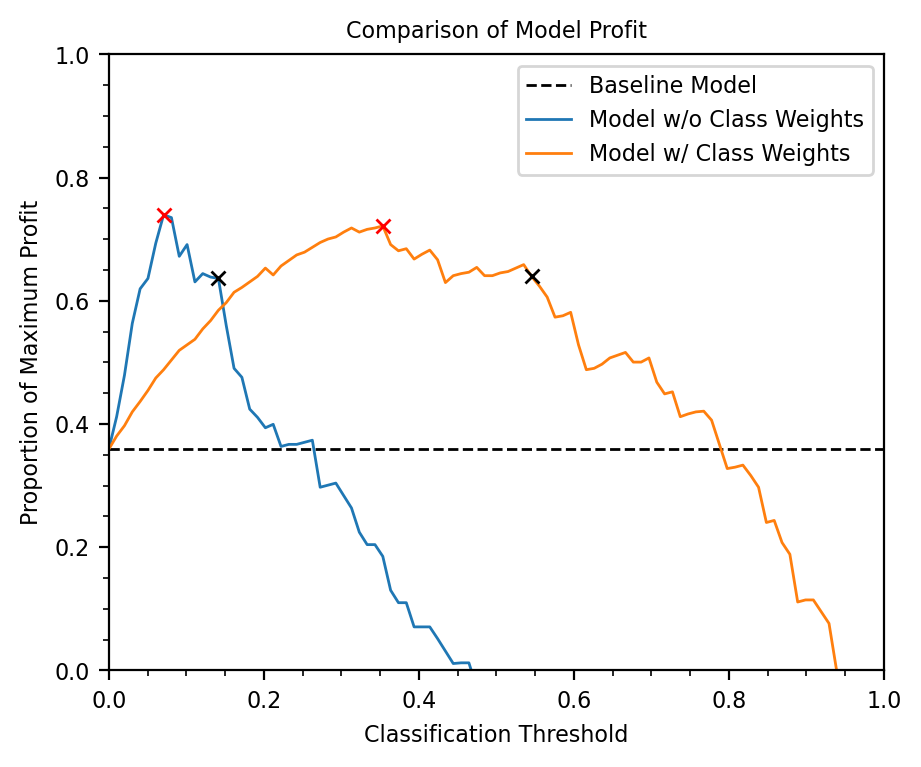

In [68]:
fig, axs = subplots(nrows=1, ncols=1, figsize=(5, 4))

axs.plot([0, 1], [baseline_profit/max_profit, baseline_profit/max_profit], '--k', lw=1)

axs.plot(threshold, np.array(profit_wo)/max_profit, lw=1)
axs.plot(threshold, np.array(profit_wi)/max_profit, lw=1)

axs.plot([threshold[np.argmin(np.abs(threshold - threshold_a[np.argmax(tpr_a + (1 - fpr_a))]))],
          threshold[np.argmin(np.abs(threshold - threshold_b[np.argmax(tpr_b + (1 - fpr_b))]))]],
         [profit_wo[np.argmin(np.abs(threshold - threshold_a[np.argmax(tpr_a + (1 - fpr_a))]))] / max_profit,
          profit_wi[np.argmin(np.abs(threshold - threshold_b[np.argmax(tpr_b + (1 - fpr_b))]))] / max_profit], 'xk', ms=5)

axs.plot([threshold[np.argmax(np.array(profit_wo))],
          threshold[np.argmax(np.array(profit_wi))]],
         [np.max(profit_wo)/ max_profit,
          np.max(profit_wi)/ max_profit], 'xr', ms=5)

axs.minorticks_on()
axs.tick_params(axis='both', labelsize=8)

axs.set_ylim(0, 1)
axs.set_xlim(0, 1)
axs.set_ylabel('Proportion of Maximum Profit', fontsize=8)
axs.set_xlabel('Classification Threshold', fontsize=8)
axs.set_title('Comparison of Model Profit', fontsize=8)
axs.legend(['Baseline Model', 'Model w/o Class Weights', 'Model w/ Class Weights'], fontsize=8);

We can see that both models reach approximately the same maximum profit but at different classification thresholds. The black points denote the expected profit using the ROC elbow values and the red points mark the maximum possible profit achievable by the models. Let's see what these maximum profits are.

In [66]:
compute_cost_metrics('Without Class Weights, Optimal Profit Threshold',
                     y_actual=y_te,
                     y_predict=predict_wo >= threshold[np.argmax(profit_wo)],
                     max_profit=max_profit)


        Without Class Weights, Optimal Profit Threshold
        Revenue: $4,900
        Costs: $1,605
        Total profit: $3,295
        Percent of max: 74.0%
        


In [67]:
compute_cost_metrics('With Class Weights, Optimal Profit Threshold',
                     y_actual=y_te,
                     y_predict=predict_wi >= threshold[np.argmax(profit_wi)],
                     max_profit=max_profit)


        With Class Weights, Optimal Profit Threshold
        Revenue: $4,850
        Costs: $1,635
        Total profit: $3,215
        Percent of max: 72.2%
        


The **Without Class Weights Model** achieves a profit that is over twice the profit of the **Baseline Model**, reaching 74% that of the **Perfect Model**.